*New and tidied up notebook for faster and easier testing of the models*

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import wandb
from log_analyzer.application import Application

from log_analyzer.train_loop import init_from_config_classes, train_model, eval_model, get_model_config
from log_analyzer.config import TrainerConfig
import log_analyzer.data.data_loader as data_utils

print(cuda := torch.cuda.is_available())
# torch.manual_seed(1)

False


# Parameter setting

In [2]:
def set_args(bidir, model_type, token_level):
    """Prepares a dictionary of settings that can be used for testing."""
    args = {}

    args["bidirectional"] = bidir
    args["model_type"] = model_type
    args["tokenization"] = token_level
    args["counts_file"] = "../data/counts678.json"
    trainer_config = TrainerConfig.init_from_file("../config/lanl_config_trainer.json")
    trainer_config.train_files = ["6.csv", "7.csv"]
    trainer_config.test_files = ["8.csv"]
    trainer_config.train_batch_size = 64
    trainer_config.eval_batch_size = 1
    args["trainer_config"] = trainer_config

    model_config_file = f"../config/lanl_config_{model_type}.json"

    args["model_config"] = get_model_config(model_config_file, model_type)

    args["data_folder"] = "../data/test_data"

    # Return the prepared args
    return args

In [13]:
# Note: hyperparameters, such as learning rate and patience, are read in from the config file.
#       (Change them there if you want to try other values)

# Specify the configuration of the model
# All combinations currently supported except bidir + tiered
bidir = True
model_type = "transformer"  # 'lstm', 'tiered-lstm', 'transformer'
token_level = "word-global"  # 'word' or 'char'

# Get the args for the model version defined above
args = set_args(bidir, model_type, token_level)

os.environ["WANDB_MODE"] = "offline"  # 'online' to auto-sync, 'offline' otherwise
os.environ["WANDB_NOTEBOOK_NAME"] = "train_model.ipynb"

wandb.init(project="logml", entity="log-data-ml", config=args)


# Train model
### (One epoch, full dataset)


Valid: 0: 100%|██████████| 40/40 [00:00<00:00, 1067.32it/s]

Valid: 1: 100%|██████████| 40/40 [00:00<00:00, 976.08it/s]

Valid: 2: 100%|██████████| 40/40 [00:00<00:00, 879.51it/s]


Valid: 3: 100%|██████████| 40/40 [00:00<00:00, 385.47it/s]

100%|██████████| 1/1 [00:00<00:00, 1231.81it/s]


{'eval/loss': 3.3881612182540266e-08,
 'eval/token_accuracy': 0.34400000000000014,
 'eval/token_perplexity': 1.0000000338816133,
 'eval/AUC': 0.1407035175879397,
 'eval/AP': 0.005681818181818182,
 'eval/AUC_(normalised)': 0.1407035175879397,
 'eval/AP_(normalised)': 0.007575757575757576}

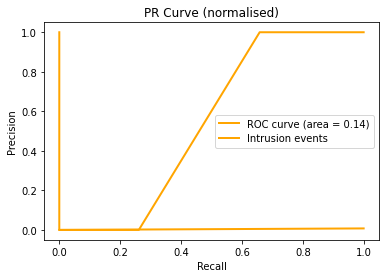

In [14]:
# Create and train the model
trainer, evaluator, train_loader, val_loader, test_loader = init_from_config_classes(**args)
train_losses = train_model(trainer, train_loader, val_loader)
test_losses = eval_model(evaluator, test_loader, store_eval_data=True)
# Evaluate the model
evaluator.run_all()

Text(0.5, 1.0, 'Training losses - Bidirectional transformer, word-global token.')

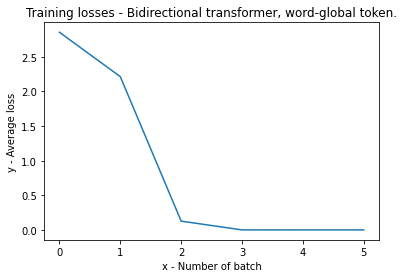

In [15]:
# Plot the train loss over time
plt.plot(train_losses)
# plt.ylim((0, 5))
# naming the x axis
plt.xlabel("x - Number of batch")
# naming the y axis
plt.ylabel("y - Average loss")
plt.title(f"Training losses - {'Bidirectional' if bidir else 'Forward'} {model_type}, {token_level} token.")

In [16]:
evaluator.prepare_evaluation_data()
print(f"Final test loss (avg): {evaluator.get_test_loss()}")
print(f"Token accuracy:        {evaluator.get_token_accuracy()}")
print(f"Token perplexity:      {evaluator.get_token_perplexity()}")

100%|██████████| 117/117 [00:00<00:00, 73221.96it/s]

Final test loss (avg): 3.3881612182540266e-08
Token accuracy:        0.34400000000000014
Token perplexity:      1.0000000338816133


100%|██████████| 1/1 [00:00<00:00, 1517.48it/s]


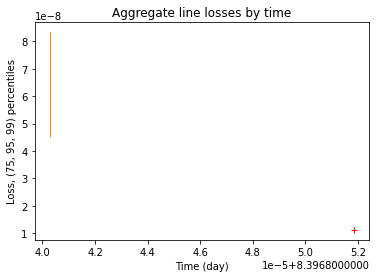

In [17]:
evaluator.plot_line_loss_percentiles(percentiles=[75, 95, 99], smoothing=300, ylim=(-1, -1), outliers=1, legend=False)

(0.1407035175879397, <module 'matplotlib.pyplot' from '/home/jakob/miniconda3/envs/log-ml/lib/python3.9/site-packages/matplotlib/pyplot.py'>)


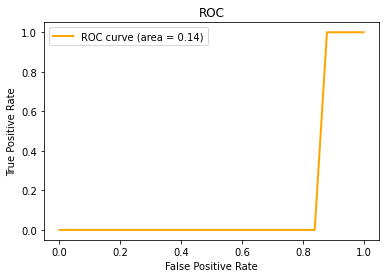

In [18]:
print(evaluator.plot_roc_curve())

# Spot check model performance

In [19]:
# Grab the first batch from the test_loader
for batch in test_loader:
    break

split_batch = test_loader.split_batch(batch)

loss, output = evaluator.eval_step(split_batch)
# The input/output of tiered models have an additional dimension, which we have to squeeze out
preds = torch.argmax(output[0], dim=-1)[0] if "tiered" in args["model_type"] else torch.argmax(output[0], dim=-1)
gt = batch["target"][0][0][: len(preds)] if "tiered" in args["model_type"] else batch["target"][0][: len(preds)]

# Get the ground truth ('target') of the first line in the batch extracted above
print(f"Ground truth: {gt}")
print(f"Model prediction: {preds}")
print(f"Loss: {loss}")

Ground truth: tensor([0, 0, 0, 0, 0, 5, 0, 0, 0, 0])
Model prediction: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
Loss: 1.728201581840949e-08



# Overfit model

### (100+ epochs, 1-10 log lines, train=test set)

### (By overfitting LSTM model on a small dataset, let me check whether the model has ability to learn the relation between input and output)


In [20]:
# Set batch_size to 1 so we train on a single line only
args["trainer_config"].train_batch_size = 1
trainer, evaluator, train_loader, val_loader, test_loader = init_from_config_classes(**args)


for batch in train_loader:
    break

split_batch = test_loader.split_batch(batch)

train_losses = []
epochs = 500
# tqdm provides a nice and minimal progress bar + time estimate for the loop
# If tqdm is not installed, simply comment the line out and use the alternatives below instead
# for i in range(epochs):
#    if i % 250 == 0:
#        print('Epoch: {i}')
for i in tqdm(range(epochs)):
    loss, _ = trainer.train_step(split_batch)  # We ignore the early_stopping flag
    train_losses.append(loss.item())

  0%|          | 0/500 [00:00<?, ?it/s]

Text(0, 0.5, 'y - Average loss')

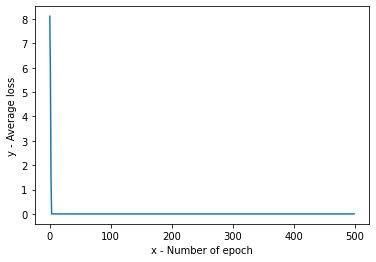

In [21]:
# Plot the train loss over time
plt.plot(train_losses)

# naming the x axis
plt.xlabel("x - Number of epoch")
# naming the y axis
plt.ylabel("y - Average loss")

In [22]:
loss, output = evaluator.eval_step(split_batch)
# The input/output of tiered models have an additional dimension, which we have to squeeze out
preds = torch.argmax(output[0], dim=-1)[0] if "tiered" in args["model_type"] else torch.argmax(output[0], dim=-1)
gt = batch["target"][0][0][: len(preds)] if "tiered" in args["model_type"] else batch["target"][0][: len(preds)]

# Get the ground truth ('target') of the first line in the batch extracted above
print(f"Ground truth: {gt}")
print(f"Model prediction: {preds}")
print(f"Loss: {loss}")

Ground truth: tensor([5, 0, 0, 0, 5, 5, 0, 5, 0, 5])
Model prediction: tensor([5, 5, 5, 5, 5, 5, 5, 5, 5, 5])
Loss: 8.829320607972591e-10
